#PIXEL ART | VAE Sprite Generator
The goal of this notebook is to train a Convolutional VAE that can generate new, coherent pixel art sprites (e.g., Pokemon, RPG items, or simple characters) and allow you to interpolate between them in the latent space.


---



###
Why a VAE


*   Stable Training: Unlike GANs, VAEs are much less likely to collapse and are generally more stable to train.

*   Meaningful Latent Space: You can smoothly interpolate between two sprites, which is very cool to visualize.

*   Explicit Encoder: You can encode any existing image into the latent space and then modify it.





##Step 1: Setup & Imports

In [1]:
 # Install opendatasets for easy Kaggle data download
!pip install opendatasets

import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
from tensorflow.keras.applications import VGG16, EfficientNetB0
from sklearn.model_selection import train_test_split

##Step 2: Get the Data
We'll use the Pokemon Images Dataset from Kaggle. It's perfect for this.

In [2]:
# Download the dataset
dataset_url = 'https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset'
od.download(dataset_url)

# Let's look at what we have
data_dir = '/content/pokemon-images-dataset/pokemon'
print(os.listdir(data_dir))

Skipping, found downloaded files in "./pokemon-images-dataset" (use force=True to force download)
['pokemon']


##Step 3: Preprocess the Images
We need to load them, resize them to a standard size (64x64),
and normalize the pixel values.

Loaded 819 images.
Image shape: (64, 64, 3)


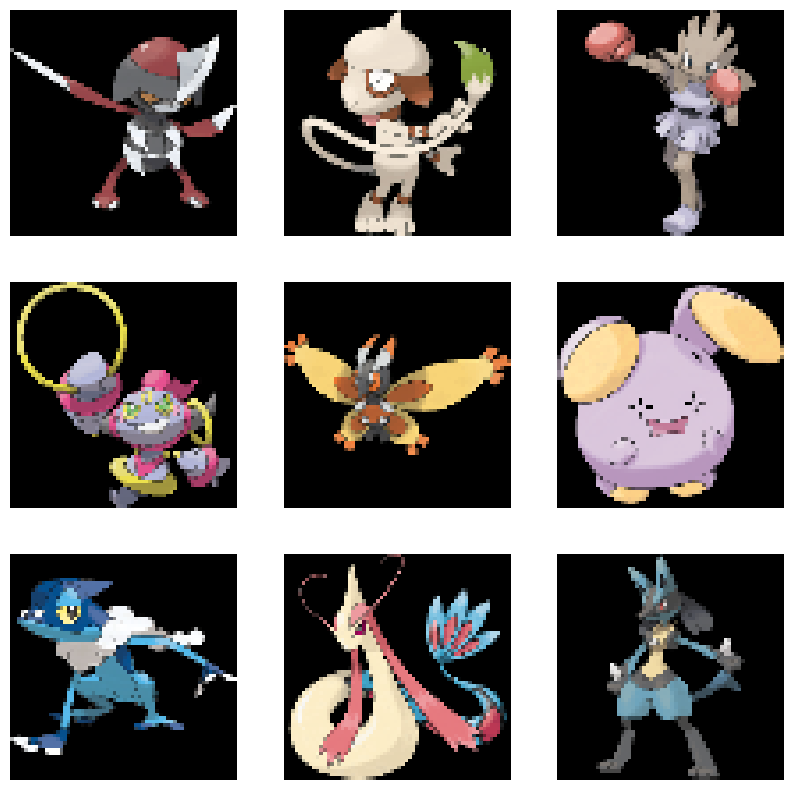

In [3]:
IMG_SIZE = 64
CHANNELS = 3

def load_and_preprocess_data(data_path):
    images = []
    for filename in os.listdir(data_path):
        img_path = os.path.join(data_path, filename)
        try:
            # Read image
            img = cv2.imread(img_path)
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    # Convert to numpy array and normalize
    images = np.array(images, dtype=np.float32)
    images = images / 255.0  # Normalize to [0, 1]
    return images

# Load the data
data_dir = '/content/pokemon-images-dataset/pokemon/pokemon' # Corrected data directory
images = load_and_preprocess_data(data_dir)
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape}")

# Visualize a few samples
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

##Step 4: Build the VAE Model
We'll build a Convolutional VAE.

In [4]:
class SimpleVAE(keras.Model):
    def __init__(self, latent_dim=128, image_size=64, **kwargs):
        super(SimpleVAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.image_size = image_size

        # Build components
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        # Track losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_encoder(self):
        """Simple but effective encoder"""
        inputs = keras.Input(shape=(self.image_size, self.image_size, 3))

        x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.GlobalAveragePooling2D()(x)

        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)

        return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

    def build_decoder(self):
        """Powerful decoder for clear images"""
        latent_inputs = keras.Input(shape=(self.latent_dim,))

        x = layers.Dense(4 * 4 * 256)(latent_inputs)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.Reshape((4, 4, 256))(x)

        # Upsampling with more capacity in decoder
        x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2DTranspose(32, 4, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2DTranspose(16, 4, strides=2, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

        return keras.Model(latent_inputs, outputs, name="decoder")

    def sample(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sample(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sample(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # Focus on reconstruction quality
            reconstruction_loss = tf.reduce_mean(
                tf.square(data - reconstruction)
            ) * self.image_size * self.image_size * 3

            # Very small KL weight to prioritize clear images
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # TINY beta - focus on image quality!
            total_loss = reconstruction_loss + 0.001 * kl_loss  # Very small beta!

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var = self.encoder(data)
        z = self.sample(z_mean, z_log_var)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            tf.square(data - reconstruction)
        ) * self.image_size * self.image_size * 3

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = reconstruction_loss + 0.001 * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

##Step 5: Train the Model

In [5]:
# Split data into training and validation sets
x_train, x_val = train_test_split(images, test_size=0.1, random_state=42)
print(f"Training on {len(x_train)} images, validating on {len(x_val)} images")

# Create and compile
vae = SimpleVAE(latent_dim=128, image_size=64)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# Train
history = vae.fit(
    x_train,
    epochs=1000,
    batch_size=16,
    shuffle=True,
    validation_data=(x_val,),
    verbose=1
)

Training on 737 images, validating on 82 images
Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step - kl_loss: 1.8299 - reconstruction_loss: 2129.5261 - total_loss: 2129.5281 - val_kl_loss: 21.8639 - val_reconstruction_loss: 1581.2772 - val_total_loss: 1581.2992
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - kl_loss: 56.0680 - reconstruction_loss: 1419.7687 - total_loss: 1419.8246 - val_kl_loss: 146.4329 - val_reconstruction_loss: 1021.1640 - val_total_loss: 1021.3104
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - kl_loss: 146.3688 - reconstruction_loss: 1099.2021 - total_loss: 1099.3485 - val_kl_loss: 51.1067 - val_reconstruction_loss: 929.0493 - val_total_loss: 929.1003
Epoch 4/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - kl_loss: 42.3578 - reconstruction_loss: 1013.9770 - total_loss: 1014.0193 - val_kl_loss: 27.0300 - val_reconstruction_loss: 868.4578 - val_total_loss: 868.4848
Epoch 5/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - kl_loss: 31.5670 - recon

##Step 6: Generate New Samples



Generating new samples...


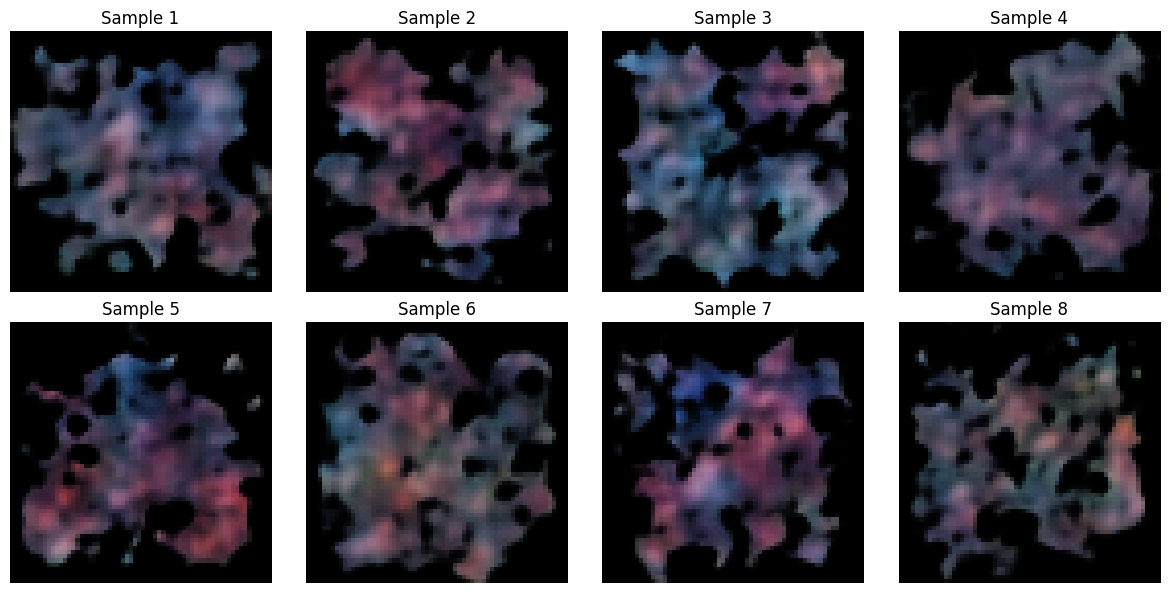

In [6]:
# Generate new samples from random noise
def generate_samples(model, num_samples=8):
    print("Generating new samples...")
    random_latent_vectors = tf.random.normal(shape=(num_samples, model.latent_dim))
    generated_images = model.decoder(random_latent_vectors)

    # Plot the generated images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

    return generated_images

# Generate samples
generated_images = generate_samples(vae, num_samples=8)

## Step 7: Reconstruct Test Images

Testing reconstruction...


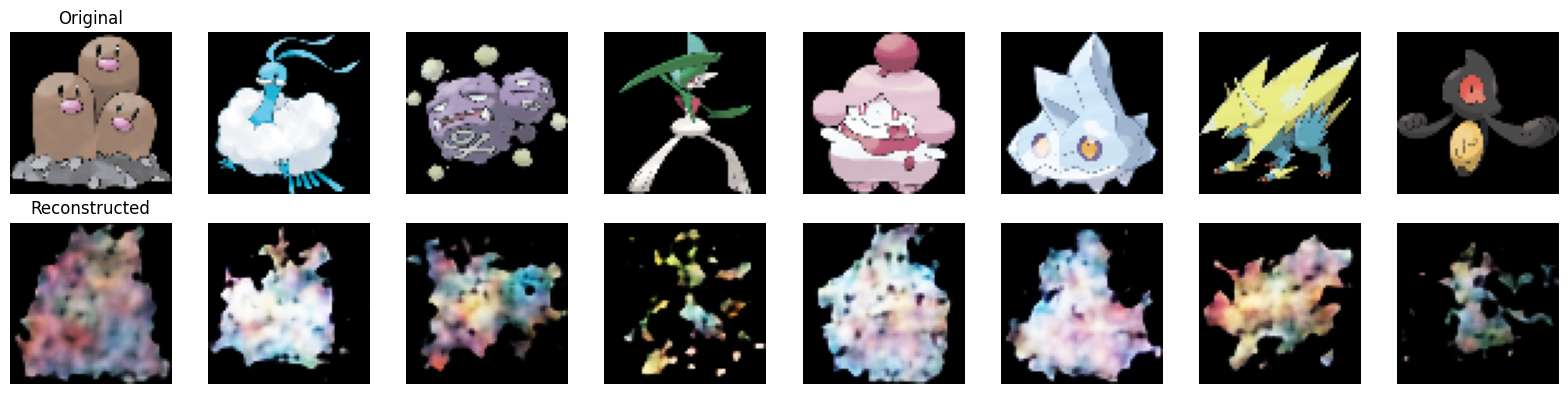

In [7]:
# Test reconstruction on validation set
def test_reconstruction(model, test_images, num_samples=8):
    print("Testing reconstruction...")

    # Select random test images
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    test_batch = test_images[indices]

    # Reconstruct
    reconstructions = model(test_batch)

    # Plot original vs reconstructed
    fig, axes = plt.subplots(2, num_samples, figsize=(2*num_samples, 4))

    for i in range(num_samples):
        # Original
        axes[0, i].imshow(test_batch[i])
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Reconstructed
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Test reconstruction
test_reconstruction(vae, x_val, num_samples=8)

## Step 8: Latent Space Interpolation

Creating interpolation...


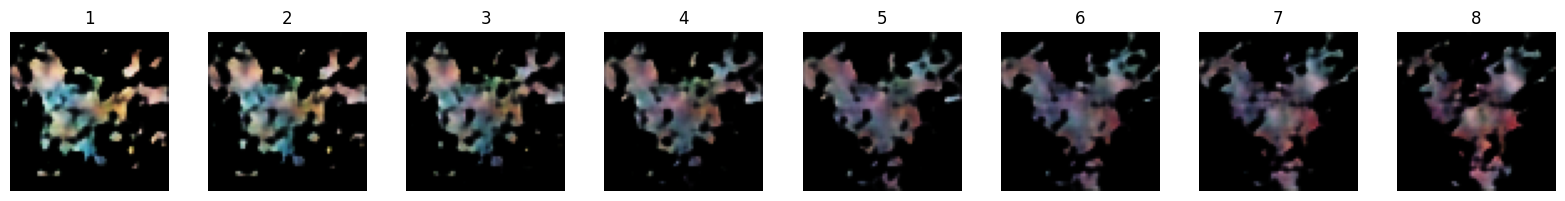

In [8]:
# Interpolate between two images in latent space
def interpolate_images(model, image1, image2, num_steps=8):
    print("Creating interpolation...")

    # Encode both images
    z_mean1, z_log_var1 = model.encoder(tf.expand_dims(image1, 0))
    z_mean2, z_log_var2 = model.encoder(tf.expand_dims(image2, 0))

    # Create interpolation points
    interpolations = []
    for alpha in np.linspace(0, 1, num_steps):
        interpolated_z = alpha * z_mean1 + (1 - alpha) * z_mean2
        interpolated_image = model.decoder(interpolated_z)
        interpolations.append(interpolated_image[0])

    # Plot interpolation
    fig, axes = plt.subplots(1, num_steps, figsize=(2*num_steps, 2))

    for i, img in enumerate(interpolations):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'{i+1}')

    plt.tight_layout()
    plt.show()

    return interpolations

# Test interpolation with random images from validation set
if len(x_val) >= 2:
    idx1, idx2 = np.random.choice(len(x_val), 2, replace=False)
    interpolations = interpolate_images(vae, x_val[idx1], x_val[idx2])

## Step 9: Plot Training History

Plotting training history...


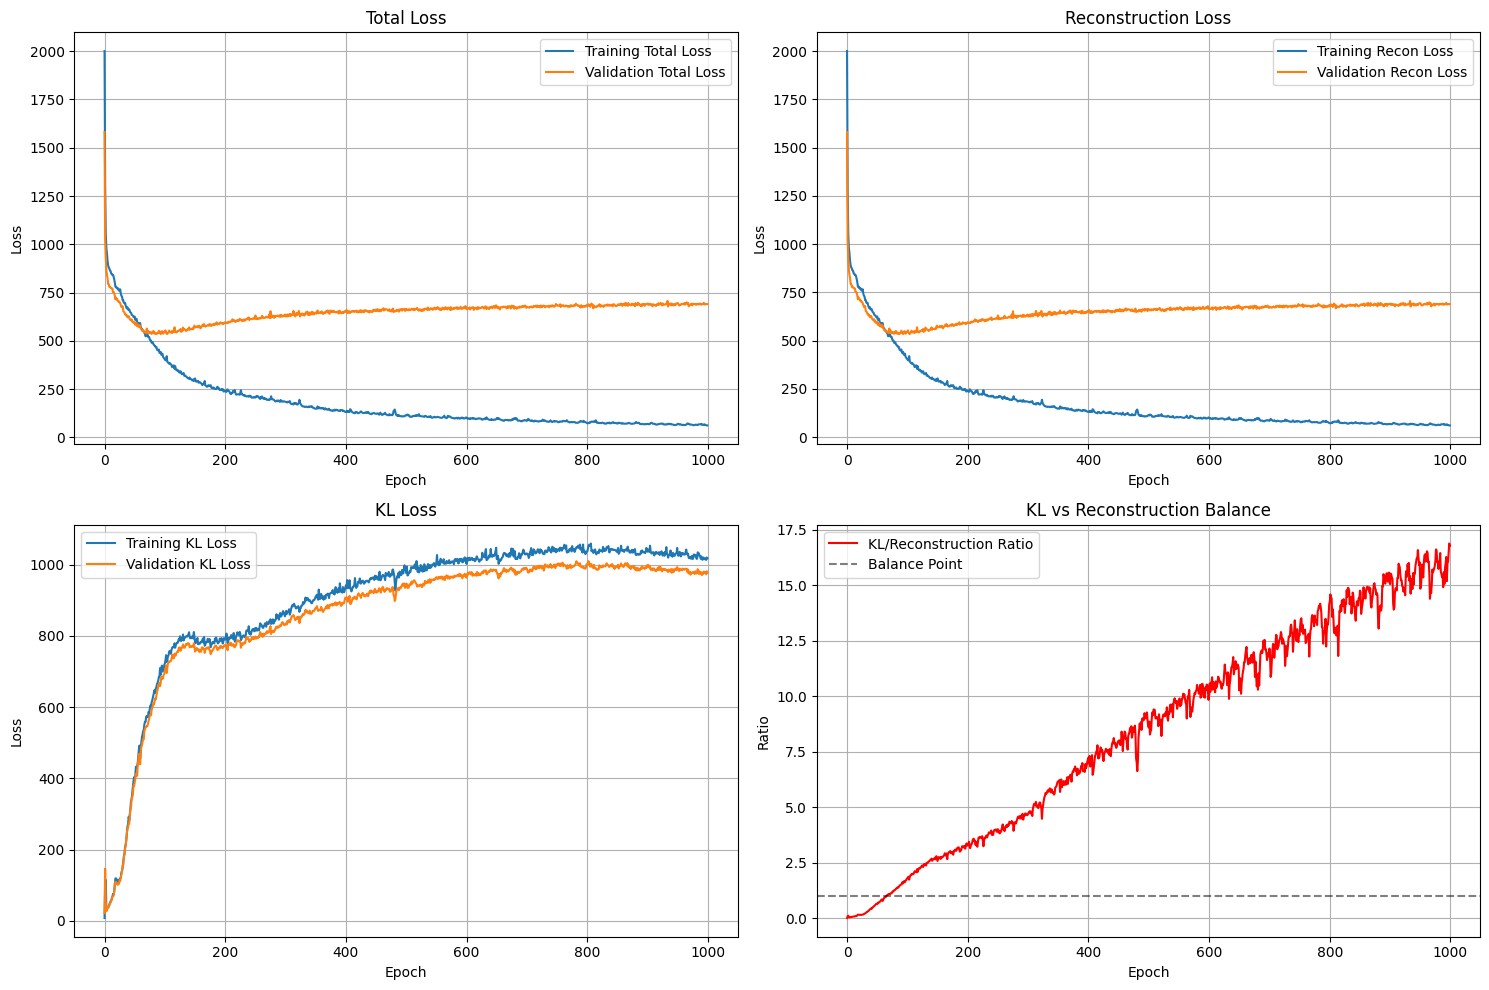

In [9]:
# Plot training history
def plot_training_history(history):
    print("Plotting training history...")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total Loss
    ax1.plot(history.history['total_loss'], label='Training Total Loss')
    if 'val_total_loss' in history.history:
        ax1.plot(history.history['val_total_loss'], label='Validation Total Loss')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Reconstruction Loss
    ax2.plot(history.history['reconstruction_loss'], label='Training Recon Loss')
    if 'val_reconstruction_loss' in history.history:
        ax2.plot(history.history['val_reconstruction_loss'], label='Validation Recon Loss')
    ax2.set_title('Reconstruction Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # KL Loss
    ax3.plot(history.history['kl_loss'], label='Training KL Loss')
    if 'val_kl_loss' in history.history:
        ax3.plot(history.history['val_kl_loss'], label='Validation KL Loss')
    ax3.set_title('KL Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True)

    # Loss Ratio (KL/Reconstruction)
    if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
        kl_loss = np.array(history.history['kl_loss'])
        recon_loss = np.array(history.history['reconstruction_loss'])
        ratio = kl_loss / (recon_loss + 1e-8)  # Avoid division by zero

        ax4.plot(ratio, label='KL/Reconstruction Ratio', color='red')
        ax4.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Balance Point')
        ax4.set_title('KL vs Reconstruction Balance')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Ratio')
        ax4.legend()
        ax4.grid(True)

    plt.tight_layout()
    plt.show()

# Plot history
plot_training_history(history)

Testing with lower beta for generation...
Generating new samples...


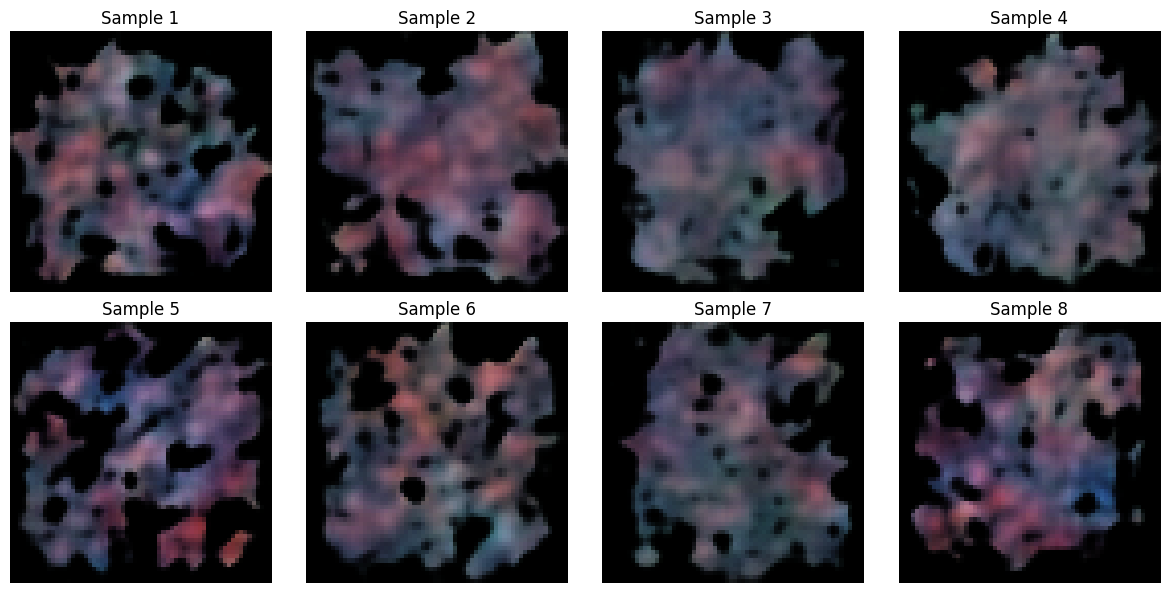

Testing reconstruction...


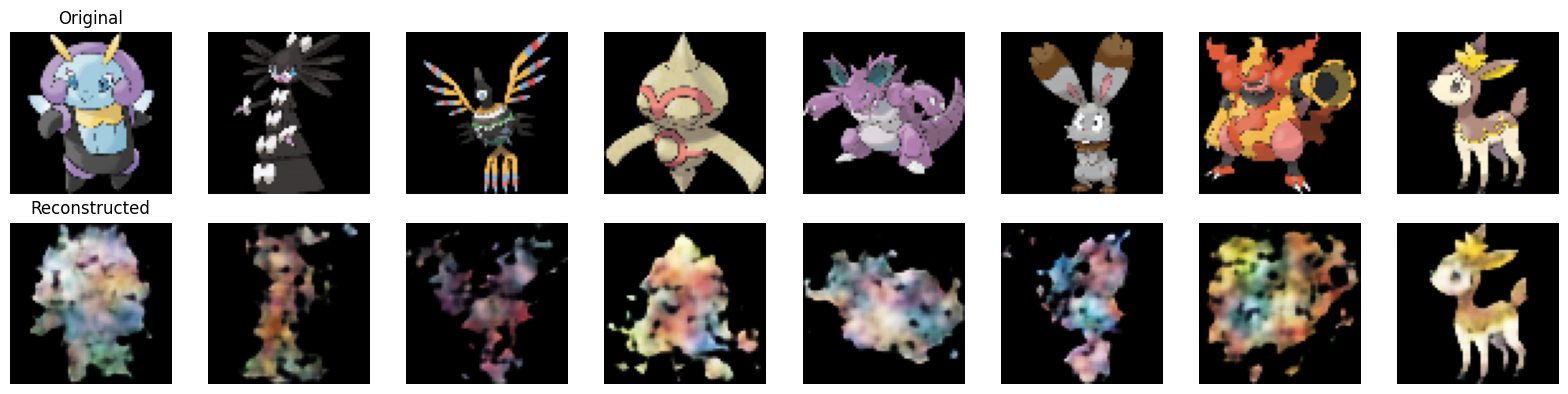

In [10]:
# Temporarily lower beta for generation
print("Testing with lower beta for generation...")
vae.beta = 0.00001  # Drastically lower beta

# Test generation again
test_generated = generate_samples(vae, num_samples=8)
test_reconstruction(vae, x_val, num_samples=8)